# [__UCI Heart Disease Dataset__](http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/) - Classification Problem

### __Aim__
To analyse the dataset(s) and __*classify*__ if a patient has Coronary Artery Disease (CAD).

### __Feature Summary__

|S.No.|Feature|Description|Type|Values|
|-----|:------|:----------|:---|:-----|
|1|age| age in years|numeric||
|2|sex| sex |categorical|(1 = male; 0 = female)|
|3|cp| chest pain type|categorical|( 1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)|
|4|trestbps| resting blood pressure (in mm Hg on admission to the hospital)|numeric||
|5|chol| serum cholestoral in mg/dl|numeric||
|6|fbs| (fasting blood sugar > 120 mg/dl) |categorical|(1 = true; 0 = false)|
|7|restecg| resting electrocardiographic results|numeric||
|8|thalach| maximum heart rate achieved|numeric||
|9|exang| exercise induced angina |categorical|(1 = yes; 0 = no)|
|10|oldpeak| st depression induced by exercise relative to rest|ordinal|(0 =  normal; 1=  having ST-T wave abnormality; 2=showing probable or definite left ventricular hypertrophy)|
|11|slope| the slope of the peak exercise ST segment|categorical|(1 = upsloping; 2 = flat; 3 = downsloping)|
|12|ca| number of major vessels (0-3) colored by flourosopy|discrete||
|13|thal| Thalium 201 stress scintigraphy|categorical|(3 = normal; 6 = fixed defect; 7 = reversable defect)|
|14|num| diagnosis of heart disease (angiographic disease status)|categorical|(0 = less than 50% narrowing in any major vessel; 1-4 = more than 50% narrowing in 1-4 vessels)|

            

### __Approach__

1. [Load the dataset](#load_data) - combine the datasets
2. Explore the variables - [correlation plots](#corr_plot) (heatmap, jointplot), countplots, [radar plots](#radar_plot) and [pareto plots](#pareto_plot). Summarise [Key Insights](#key_insights)
3. Clean the data. Consider 999 as missing/ NaN value for categorial variable. Drop all the missing values for the numeric variables
4. Split the data (70-30 Train-Test)
5. Build and predict the models
6. Evaluate the accuracy and AUC of the models
7. Build a Jupyter Dashboard displaying the following
 - Countplots
 - Radar plots
 - Correlation plots
 - Pareto plots
 - Model Accuracy and AUC

### __Libraries__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

### __Load the dataset(s)__<a id='load_data'></a>

In [2]:
# Load the datasets. Provide the column names for all of them
colnames = ['age','sex','cp', 'trestbps','chol', 'fbs','restecg', 'thalach','exang','oldpeak','slope','ca','thal','num']
     
cleveland = pd.read_csv('processed.cleveland.data', names=colnames)
hungarian = pd.read_csv('processed.hungarian.data',names=colnames)
longbeach = pd.read_csv('processed.va.data', names=colnames)
switzerland = pd.read_csv('processed.switzerland.data', names=colnames)

In [3]:
# Add a dataset column and fill the values with the dataset name
cleveland['dataset'] = 'cleveland'
hungarian['dataset'] = 'hungarian'
longbeach['dataset'] = 'longbeach'
#switzerland['dataset'] = 'switzerland' 

In [4]:
# Concatenate all four datasets to a single dataset
# Dropping Swiss data - too many NaNs
comb = [cleveland, hungarian, longbeach]#, switzerland]
heart = pd.concat(comb, ignore_index=True)

In [5]:
# Check the dataset
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,dataset
0,63.0,1.0,1.0,145,233,1,2,150,0,2.3,3,0.0,6.0,0,cleveland
1,67.0,1.0,4.0,160,286,0,2,108,1,1.5,2,3.0,3.0,2,cleveland
2,67.0,1.0,4.0,120,229,0,2,129,1,2.6,2,2.0,7.0,1,cleveland
3,37.0,1.0,3.0,130,250,0,0,187,0,3.5,3,0.0,3.0,0,cleveland
4,41.0,0.0,2.0,130,204,0,2,172,0,1.4,1,0.0,3.0,0,cleveland


In [6]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 15 columns):
age         797 non-null float64
sex         797 non-null float64
cp          797 non-null float64
trestbps    797 non-null object
chol        797 non-null object
fbs         797 non-null object
restecg     797 non-null object
thalach     797 non-null object
exang       797 non-null object
oldpeak     797 non-null object
slope       797 non-null object
ca          797 non-null object
thal        797 non-null object
num         797 non-null int64
dataset     797 non-null object
dtypes: float64(3), int64(1), object(11)
memory usage: 93.5+ KB


We need to convert the columns to float and category accordibnlgy


In [7]:
# Convert the columns  
for col in heart.columns:
    heart[col].replace(['?',''], np.nan, inplace=True)
    
    # Type conversion for columns
    if col in ['sex','cp','fbs','restecg','exang','slope','ca','thal','num']:
        heart[col].replace(np.nan, 999, inplace=True)
        heart[col] = heart[col].astype(float)
        heart[col] = heart[col].astype(int)
    elif col == 'dataset':
        pass
    else:
        heart[col] = heart[col].astype(float)

In [8]:
# Function to create a disease variable
def create_var(x):
    if x > 0.0:
        return 1
    else:
        return 0

In [9]:
# Create a disease variable
heart['disease'] = heart['num'].apply(lambda x: create_var(x))

In [11]:
# Check NaNs for each column
heart.isnull().sum()

age          0
sex          0
cp           0
trestbps    57
chol        30
fbs          0
restecg      0
thalach     54
exang        0
oldpeak     56
slope        0
ca           0
thal         0
num          0
dataset      0
disease      0
dtype: int64

In [12]:
# Replace 0's in numerical variables with NaNs
heart['chol'].replace(0.0, np.nan, inplace=True)
heart['trestbps'].replace(0.0, np.nan, inplace=True)
# Drop NaNs
heart.dropna(axis=0, how='any', inplace=True)

### __Exploratory Data Analysis__

#### Boxplots

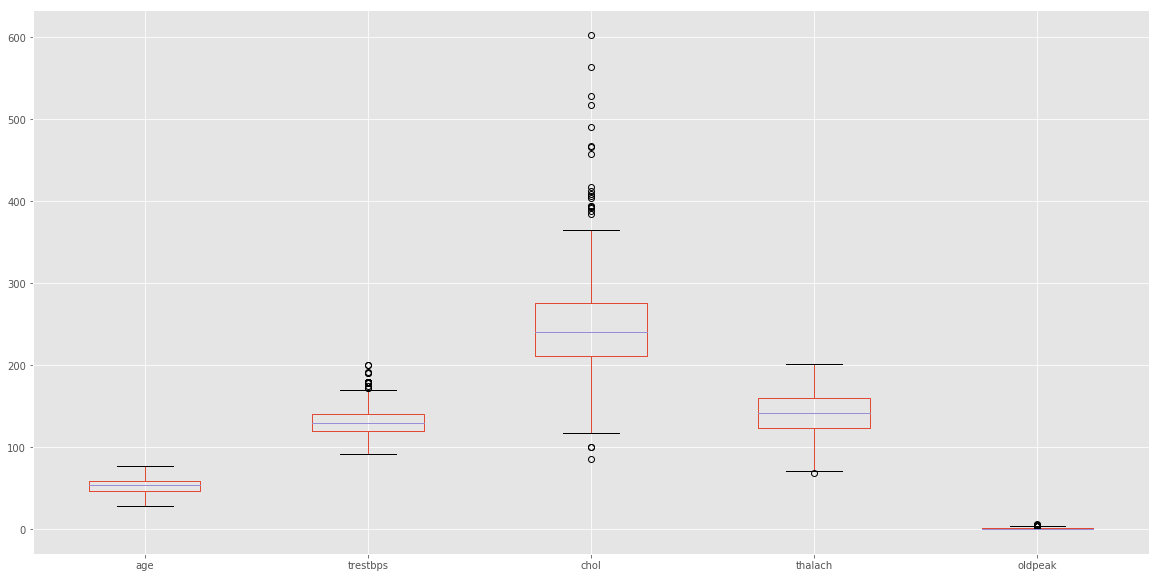

In [13]:
heart.boxplot(column=['age','trestbps', 'chol', 'thalach','oldpeak'], figsize=(20,10))

> There are quite a few outliers for *chol* and *trestbps* columns

#### Correlations <a id='corr_plot'></a>

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


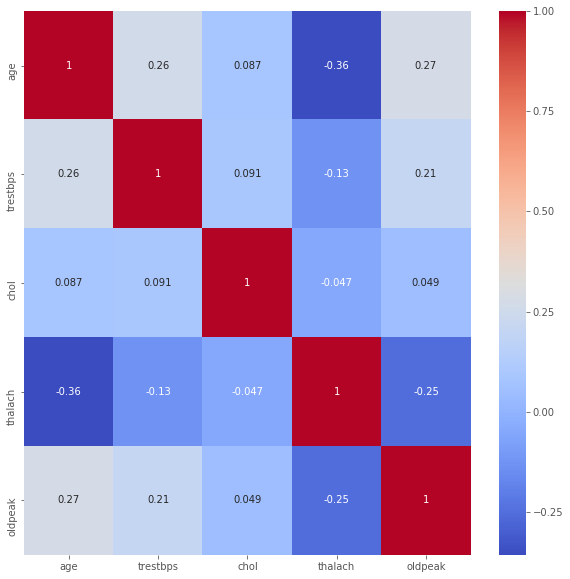

In [14]:
# Heatmap for the numerical variables
heart_numeric = heart.drop(['sex','cp','fbs','restecg','exang','slope','ca','thal','num','disease','dataset'], axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(heart_numeric.corr(),annot=True, cmap='coolwarm')

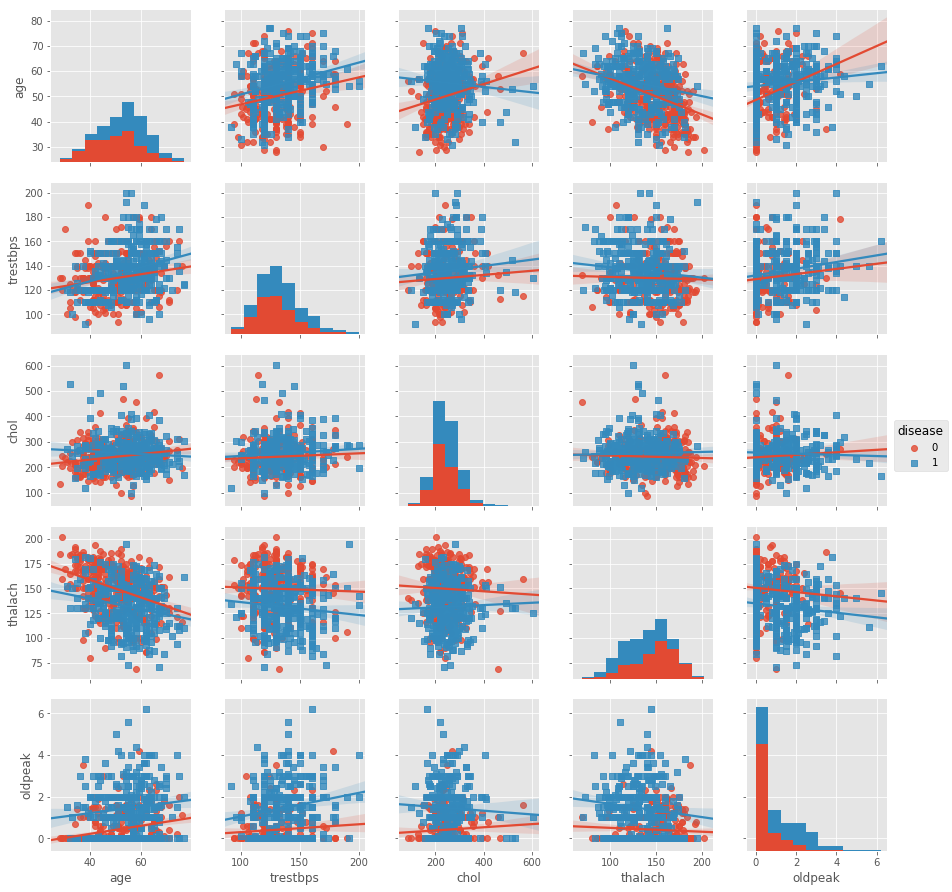

In [15]:
# Pairplot for numeric variables
sns.pairplot(heart,vars=[col for col in heart.columns if col not in ['sex','cp','fbs','restecg','exang','slope','ca','thal','num', 'disease','dataset']], hue='disease',markers=['o','s'],kind='reg')

#### Correlation Summary

From the heatmap and the pairplots, we notice that
1. Negative correlation between 
 - *thalach* and *age*
2. Positive correlation between 
 - *trestbps* and *age*
 - *oldpeak* and *age*
 - *trestbps* and *oldpeak*
3. Weak positive correlation between
 - *chol* and *age*
 - *chol* and *trestbps*
4. Weak negative correlation between
 - *trestpbs* and *thalach*
5. Negative correlation for presence of disease and positive correlation for absence of disease in 
 - *chol* and *oldpeak*
 - *thalach* and *oldpeak*

#### __Countplots__

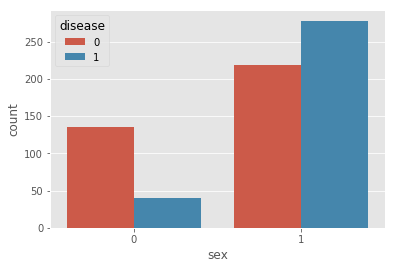

In [16]:
sns.countplot(heart['sex'], hue=heart['disease'])

sex: sex (1 = male; 0 = female)
> Males have higher risk of disease, compared to females

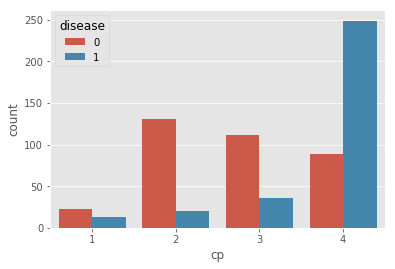

In [17]:
sns.countplot(heart['cp'], hue=heart['disease'])

cp: chest pain type
        - Value 1: typical angina
        - Value 2: atypical angina
        - Value 3: non-anginal pain
        - Value 4: asymptomatic
        
 num: diagnosis of heart disease (angiographic disease status)
        - Value 0: < 50% diameter narrowing
        - Value 1: > 50% diameter narrowing
        (in any major vessel: attributes 59 through 68 are vessels)
        
> Asymptomatic chest pain has high chances of coronary heart disease, followed by non-anginal pain 

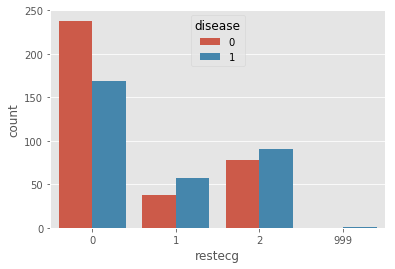

In [18]:
sns.countplot(heart['restecg'], hue=heart['disease'])

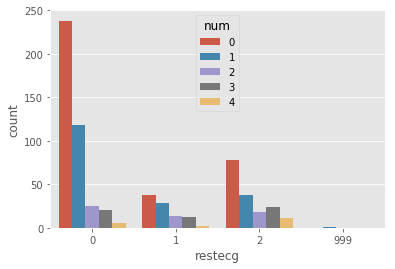

In [19]:
sns.countplot(heart['restecg'], hue=heart['num'])

restecg: resting electrocardiographic results
        - Value 0: normal
        - Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
                    elevation or depression of > 0.05 mV)
        - Value 2: showing probable or definite left ventricular hypertrophy
                    by Estes' criteria
                    
> In all cases, there are good chances of heart disease. Rest ECG alone cannot be used to diagnose the disease. It has to be complimented with another diagnosis test.

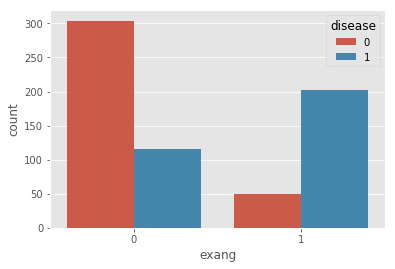

In [20]:
sns.countplot(heart['exang'], hue=heart['disease'])

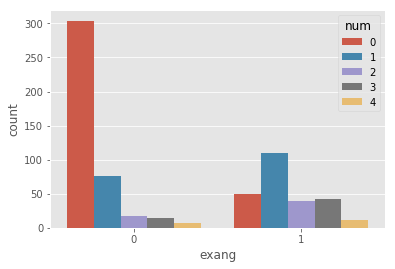

In [21]:
sns.countplot(heart['exang'], hue=heart['num'])

exang: exercise induced angina (1 = yes; 0 = no)
> Exercise induced Angina, if present, causes the narrowing of vessel #1, thereby increases the chance of heart disease

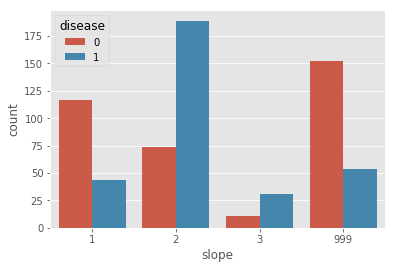

In [22]:
sns.countplot(heart['slope'], hue=heart['disease'])

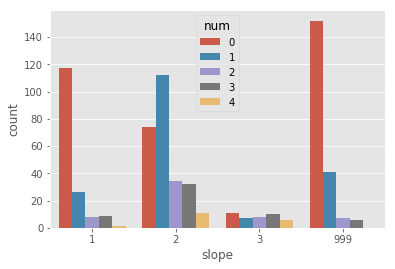

In [23]:
sns.countplot(heart['slope'], hue=heart['num'])

slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
        -- Value 999: Unknown
> Flat slope exercise has more incidents of narrowing of vessel #1, followed by vessel #2 and #3

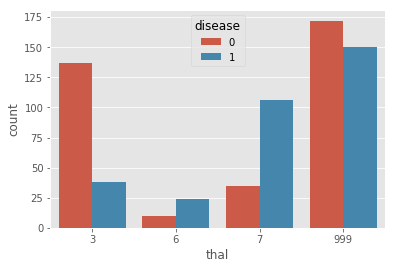

In [24]:
sns.countplot(heart['thal'], hue=heart['disease'])

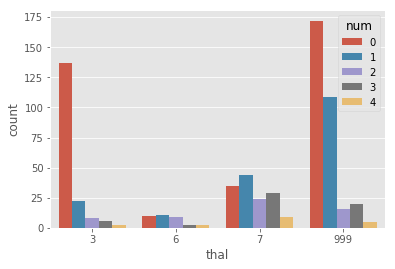

In [25]:
sns.countplot(heart['thal'], hue=heart['num'])

 thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
 
 > Reversible defect cases of *Thalium 201 stress scintigraphy* have high chances of narrowing the vessel and hence the disease

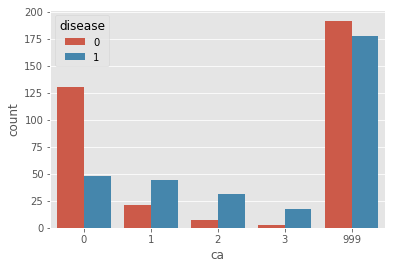

In [26]:
sns.countplot(heart['ca'], hue=heart['disease'])

ca: number of major vessels (0-3) colored by flourosopy

> Vessel #1 and #2 are the most affected in the diseased patients 

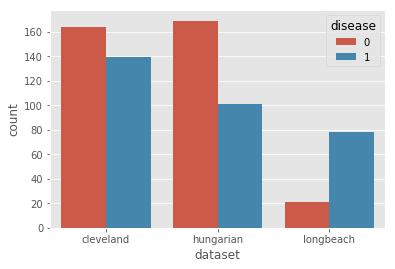

In [27]:
sns.countplot(heart['dataset'],hue=heart['disease'])

> Longbeach has highest number of diseased patients followed by Cleveland

In [28]:
#Function to plot the stacked plot for a column
def stack_plot(col_name, target, nbins):
    '''stack_plot(col_name, target, nbins)
    Function to plot the stacked plot for a column
    '''
    dct = {}
    for name in heart[target].unique():
        dct[name] = heart.groupby(target).get_group(name)[col_name]
    
    ax = pd.DataFrame(dct).plot.hist(stacked=True, bins = nbins,figsize=(6,6))
    ax.set(xlabel=col_name)
    ax.legend(title="Disease: 0=No; 1=Yes")
    
    
   

In [29]:
# Function to calculate percentage of CAD patients for a given range
def range_count(start, end, split, col_name):
    '''range_count(start, end, split, col_name)
    Function to get the count of diseases/non-diseases patients and yes/no ratio for a user-defined range in numerical features
    '''
    print("Range\t\t%Yes\tYes\tNo")
    print("----------------------------------")
    num = np.arange(start,end+1,split)
    for i in range(len(num)):
        
        if i==0:
            pass
        else:        
            a = heart[(heart[col_name] > num[i-1]) & (heart[col_name] < num[i]) & (heart['disease'] == 1)][col_name].count()
            b = heart[(heart[col_name] > num[i-1]) & (heart[col_name] < num[i]) & (heart['disease'] == 0)][col_name].count()
            if b == 0:
                print(num[i-1],"-",num[i],"\t",np.nan,"\t" ,a,"\t", b)
            else:
                print(num[i-1],"-",num[i],"  \t%.2f" % (a*100.0/float(a+b)),"\t" ,a,"\t", b)

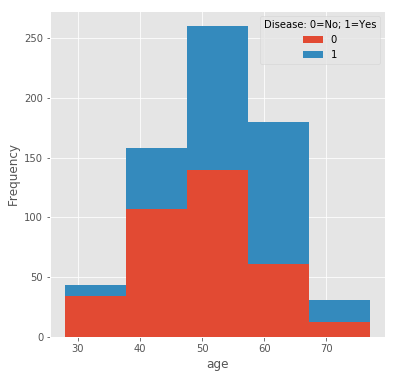

In [30]:
stack_plot('age','disease',5)

In [31]:
range_count(20,80,10,'age')

Range		%Yes	Yes	No
----------------------------------
20 - 30   	0.00 	 0 	 3
30 - 40   	26.23 	 16 	 45
40 - 50   	36.53 	 61 	 106
50 - 60   	48.44 	 124 	 132
60 - 70   	66.09 	 76 	 39
70 - 80   	60.00 	 9 	 6


> Age groups 60-70, 70-80, 50-60 and 40-50 have high chnaces of the disease

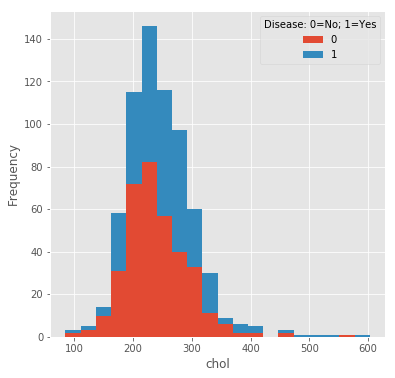

In [32]:
stack_plot('chol','disease',20)

In [33]:
range_count(50,600,50,'chol')

Range		%Yes	Yes	No
----------------------------------
50 - 100   	0.00 	 0 	 1
100 - 150   	30.00 	 3 	 7
150 - 200   	39.62 	 42 	 64
200 - 250   	44.23 	 115 	 145
250 - 300   	55.38 	 103 	 83
300 - 350   	50.70 	 36 	 35
350 - 400   	50.00 	 6 	 6
400 - 450   	60.00 	 3 	 2
450 - 500   	50.00 	 2 	 2
500 - 550 	 nan 	 2 	 0
550 - 600   	0.00 	 0 	 1


> Cholesterol >200 mg has high changes of heart disease

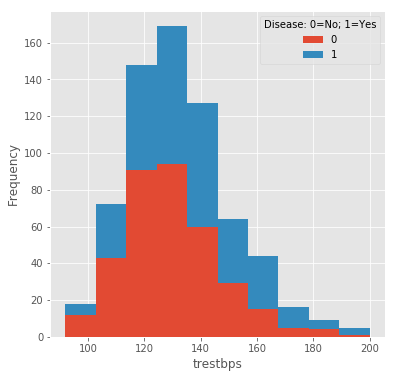

In [34]:
stack_plot('trestbps','disease',10)

In [35]:
range_count(80,200,20,'trestbps')

Range		%Yes	Yes	No
----------------------------------
80 - 100   	40.00 	 2 	 3
100 - 120   	39.36 	 37 	 57
120 - 140   	46.70 	 99 	 113
140 - 160   	61.96 	 57 	 35
160 - 180   	72.22 	 13 	 5
180 - 200   	66.67 	 2 	 1


> People with blood pressure > 140mm Hg have high chances of the disease 

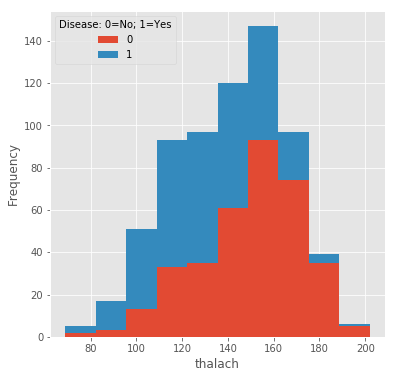

In [36]:
stack_plot('thalach','disease', 10)

In [37]:
range_count(50,250,50,'thalach')

Range		%Yes	Yes	No
----------------------------------
50 - 100   	73.17 	 30 	 11
100 - 150   	60.30 	 202 	 133
150 - 200   	25.40 	 63 	 185
200 - 250   	0.00 	 0 	 1


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


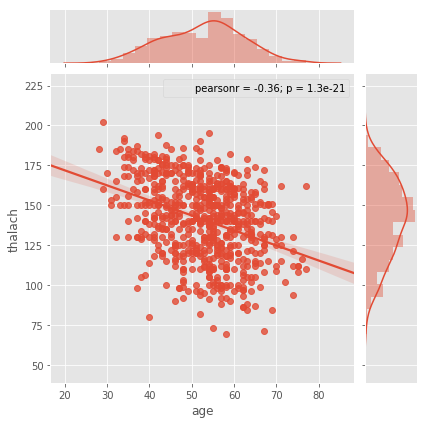

In [38]:
sns.jointplot(x='age', y='thalach', data=heart, kind='reg')

> Since age and thalach have inverse relation, older people with lesser Max heart rate achieved during exercise will be at high risk

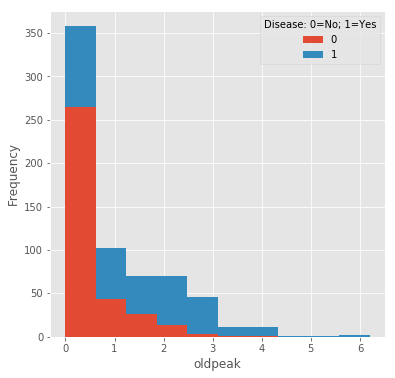

In [39]:
stack_plot('oldpeak','disease', 10)

In [40]:
range_count(0,5,1,'oldpeak')

Range		%Yes	Yes	No
----------------------------------
0 - 1   	34.21 	 26 	 50
1 - 2   	60.64 	 57 	 37
2 - 3   	88.24 	 30 	 4
3 - 4   	91.67 	 11 	 1
4 - 5   	66.67 	 2 	 1


> ST depression induced by exercise relative rest, if more than or equal 1, has high chances of disease

#### __Radar Charts__

[Reference]( https://typewind.github.io/2017/09/29/radar-chart/)

In [41]:
# Define Radar plot for the variables
# Normalised the values in the columns for easy of comparision
def radar_plot(_dataset):
    
    # Define the labels in the radar plot
    labels=np.array(['age','trestbps','chol','thalach','oldpeak','disease'])
    
    stats = []
    
    # Normalise the values
    for lab in labels:
        a = heart[heart['dataset']==_dataset][lab].mean()
        b = heart[heart['dataset']==_dataset][lab].max()
        c = heart[heart['dataset']==_dataset][lab].min()
        stats.append((a-c)/float(b-c))

    stats = np.array(stats)

    # Set the angle
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False) 
    
    
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))  
    angles=np.concatenate((angles,[angles[0]]))  

    # Plot
    fig=plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, polar=True)   
    ax.plot(angles, stats,'s--', linewidth=1.0, color='green')  
    ax.fill(angles, stats, alpha=0.2, color='green')  #Fulfill the area
    ax.set_thetagrids(angles * 180/np.pi, labels)  # Set the label for each axis
    ax.set_title(_dataset)  
    ax.grid(True)

In [42]:
# Function to plot for each dataset
def autoradar():
    for city in heart['dataset'].unique():
        radar_plot(city)

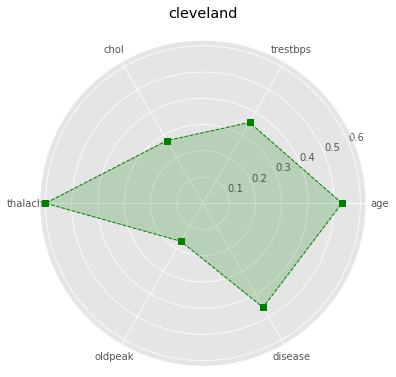

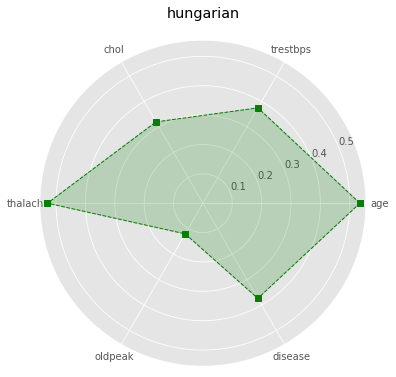

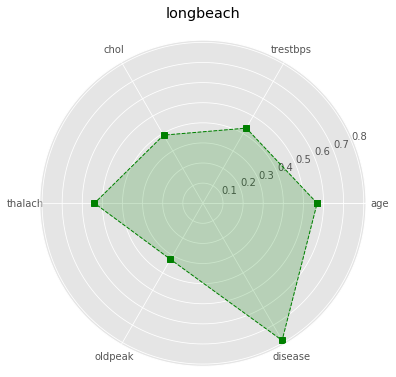

In [43]:
autoradar()

#### __EDA  - Key Insights__<a id='key_insights'></a>

1. *Males* have higher risk of disease, compared to *females*
2. *Asymptomatic* chest pain has high chances of coronary heart disease, followed by *non-anginal* pain 
3. Rest ECG alone cannot be used to diagnose the disease. It has to be complimented with another diagnosis test.
4. Exercise induced Angina, if present, causes the narrowing of vessel #1, thereby increases the chance of heart disease
5. Flat slope exercise has more incidents of narrowing of vessel #1, followed by vessel #2 and #3
6. Reversible defect cases of *Thalium 201 stress scintigraphy* have high chances of narrowing the vessel and hence the disease
7. Age groups 60-70, 70-80, 50-60 and 40-50 have high chances of the disease
8. A Cholesterol level of *>200 mg* has high change of a heart disease
9. People with blood pressure *> 140mm Hg* have high chances of the disease 
10. Older people with lesser *Max heart rate achieved* during exercise will be at high risk of the disease
11. ST depression induced by exercise relative rest, *if more than or equal 1*, has high chances of disease
12. Negative correlation between *thalach* and *age*
13. Positive correlation between 
 - *trestbps* and *age*
 - *oldpeak* and *age*
 - *trestbps* and *oldpeak* 
14. Longbeach has highest number of diseased patients followed by Cleveland
15. Hungarian dataset has people with highest mean age
16. Longbeach dataset has people with highest mean blood presure (also most no. of diseased patients)
17. Longbeach dataset has people with highest mean cholestrol (also most no. of diseased patients)
18. Cleveland dataset has people with highest mean Max. Heart rate
19. Longbeach dataset has people with highest mean *oldpeak* 


### __Model Building__

Logistic Regression and Random Forest models will be built for the available data.

#### __Convert Varible Types__

Get dummy variables for the categorical/ ordinal/discrete variables.

In [44]:
# Categorise the non-numeric variables by appending the column name
def append_col(x, col):
    return str(col)+'_'+str(x)
    

for col in heart.columns:
    if col in ['sex','cp','fbs','restecg','exang','slope','ca','thal','num']:
        heart[col] = heart[col].apply(lambda x:append_col(x,col))
    

In [45]:
# Create a new dataset dropping the numeric variables
heart_mod = heart.drop([col for col in ['sex','cp','fbs','restecg','exang','slope','ca','thal','num']], axis =1)

In [46]:
# Concatenate the dummy variables to the dataset
for col in heart.columns:
    if col in ['sex','cp','fbs','restecg','exang','slope','ca','thal','num','dataset']:
        heart_mod = pd.concat([heart_mod, pd.get_dummies(heart[col])], axis=1)


In [47]:
# Check the modified dataset
heart_mod.head()

,age,trestbps,chol,thalach,oldpeak,dataset,disease,sex_0,sex_1,cp_1,...,thal_7,thal_999,num_0,num_1,num_2,num_3,num_4,cleveland,hungarian,longbeach
0,63.0,145.0,233.0,150.0,2.3,cleveland,0,0,1,1,...,0,0,1,0,0,0,0,1,0,0
1,67.0,160.0,286.0,108.0,1.5,cleveland,1,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,67.0,120.0,229.0,129.0,2.6,cleveland,1,0,1,0,...,1,0,0,1,0,0,0,1,0,0
3,37.0,130.0,250.0,187.0,3.5,cleveland,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,41.0,130.0,204.0,172.0,1.4,cleveland,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0


In [48]:
# Drop duplicate records, if any
heart_mod.drop_duplicates(keep=False, inplace=True)

### __Split the Data__

In [49]:
# Define the predict and target variables
X = heart_mod.drop(['disease','num_0','num_1','num_2','num_3','num_4','dataset'], axis=1)
y = heart_mod['disease']

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
# Split the data to train and test sets in 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

In [52]:
# Check the shape of the split data
print(X_train.shape,y_train.shape)
print(X_test.shape, y_test.shape)

(469, 36) (469,)
(201, 36) (201,)


In [53]:
# Define function to get all the model metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
def model_metrics(X_test,y_test,y_model,obj):
    
    conf = confusion_matrix(y_test, y_model)
    tp = conf[0][0]
    fn = conf[1][0]
    tn = conf[1][1]
    fp = conf[0][1]
    
    sens = tp/float(tp+fn)
    spec = tn/float(tn+fp)
    mcc = (tp*tn - fp*fn)/float((tp+fp)*(tp+fn)*(fp+tn)*(tn+fn))**0.5
    
        
    
    y_pred_proba = obj.predict_proba(X_test)[::,1]
    fpr, tpr, threshold = roc_curve(y_test,  y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    
    
    print("Classifier:",obj)
    print("----------------------------------------------------------------------------")
    print( "Accuracy\t\t: %0.4f" % accuracy_score(y_test, y_model))
    print( "Sensitivity\t\t: %0.4f" % sens)
    print( "Specificity\t\t: %0.4f" % spec)
    print( "Matthews Corr. Coeff.\t: %0.4f" % mcc)
    print( "----------------------------------------------------------------------------")
    print( "Confusion Matrix: \n", conf)
    print( "----------------------------------------------------------------------------")
    print( "Classification Report: \n",classification_report(y_test, y_model))
    print( "----------------------------------------------------------------------------")
    
    plt.title('Receiver Operating Characteristic Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'best')
    plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([0, 1])
    #plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    

### Logistic Regression Model

In [54]:
from sklearn.linear_model import LogisticRegression

In [55]:
# Define Classifier
lr = LogisticRegression(random_state=101)

In [56]:
# Fit the model on training set
model_lr = lr.fit(X_train, y_train)

In [57]:
# Predict the model on test set
pred_lr = model_lr.predict(X_test)

Classifier: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=101, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
----------------------------------------------------------------------------
Accuracy		: 0.8308
Sensitivity		: 0.8319
Specificity		: 0.8293
Matthews Corr. Coeff.	: 0.6550
----------------------------------------------------------------------------
Confusion Matrix: 
 [[99 14]
 [20 68]]
----------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

          0       0.83      0.88      0.85       113
          1       0.83      0.77      0.80        88

avg / total       0.83      0.83      0.83       201

----------------------------------------------------------------------------


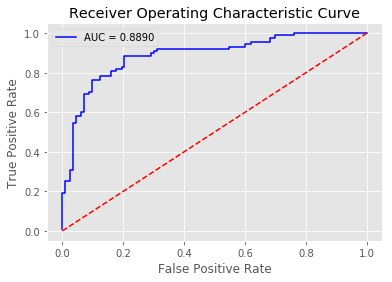

In [58]:
# Model metrics
model_metrics(X_test,y_test, pred_lr,model_lr)

### __Random Forest Model__

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
# Define classifier - tune the hyperparameters 
rf = RandomForestClassifier(n_estimators=150, max_depth=11,max_features=3,random_state=101)

In [61]:
# Fit the model
model_rf = rf.fit(X_train, y_train)

In [62]:
# Predict the model
pred_rf = model_rf.predict(X_test)

Classifier: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False)
----------------------------------------------------------------------------
Accuracy		: 0.8358
Sensitivity		: 0.8448
Specificity		: 0.8235
Matthews Corr. Coeff.	: 0.6655
----------------------------------------------------------------------------
Confusion Matrix: 
 [[98 15]
 [18 70]]
----------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

          0       0.84      0.87      0.86       113
          1       0.82      0.80      0.81        88

avg / total       0.84      0.84    

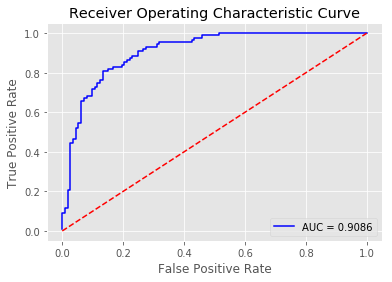

In [63]:
# Model Metrics
model_metrics(X_test,y_test,pred_rf,model_rf)

In [64]:
#Get the importance of each feature 
def feature_imp(obj):
    print(pd.DataFrame(obj.feature_importances_,index = X.columns, columns=['imp']).sort_values('imp', ascending = False))

In [65]:
feature_imp(model_rf)

                  imp
oldpeak      0.111264
cp_4         0.077031
thalach      0.077021
age          0.067324
trestbps     0.062750
chol         0.061720
exang_0      0.058471
exang_1      0.047308
thal_3       0.045111
cp_2         0.037741
slope_2      0.033762
thal_7       0.030621
ca_0         0.029178
cp_3         0.024970
sex_1        0.024527
sex_0        0.023829
slope_999    0.023468
restecg_0    0.015865
slope_1      0.015026
fbs_0        0.011886
fbs_1        0.011448
cp_1         0.010801
hungarian    0.010629
restecg_2    0.010066
ca_1         0.009983
thal_999     0.009951
longbeach    0.008904
cleveland    0.008309
ca_999       0.008219
restecg_1    0.007580
ca_2         0.007373
thal_6       0.005873
ca_3         0.005764
slope_3      0.004476
restecg_999  0.001188
fbs_999      0.000563


### Model Summary

| Classifier | Accuracy | AUC |
|------|------|------|------|
| Logistic Regression  | 0.8308| 0.8890|
| Random Forest | 0.8358| 0.9086|


<h1><center>UCI Heart Disease dataset - Dashboard</center></h1> 

In [66]:
# Import the Jupyter Dashboard related libraries
from ipywidgets import widgets, interact, interactive, interactive_output
from IPython.display import display

### Distribution

In [67]:
# No. of Bins
def stackplt(Bins,col):
    
    return stack_plot(col,'disease', Bins)#sns.distplot(heart[col], bins=Bins, kde=False, axlabel=col)
    
a = interactive(stackplt, Bins=widgets.IntSlider(min=5,max=30,step=5,value=10), col=widgets.Dropdown(
    options=['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],
    value='age',
    description='Column:',
    disabled=False))
display(a)
a.result;


interactive(children=(IntSlider(value=10, description='Bins', max=30, min=5, step=5), Dropdown(description='Co…

### Radar Plots<a id='radar_plot'></a>

In [68]:
# Radar plots
def radarplt(dataset):
    
    return radar_plot(dataset)
    
a = interactive(radarplt, dataset=widgets.Dropdown(
    options=['cleveland','hungarian','longbeach'],
    value='cleveland',
    description='Dataset:',
    disabled=False))
display(a)
a.result;

interactive(children=(Dropdown(description='Dataset:', options=('cleveland', 'hungarian', 'longbeach'), value=…

### __JointPlots__

In [69]:
# Joint plots
def jointplt(_xcol,_ycol):
    
    return sns.jointplot(x=_xcol, y=_ycol, data=heart, kind='reg', color='blue')
    
a = interactive(jointplt, _xcol=widgets.Dropdown(
    options=['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],
    value='age',
    description='x:',
    disabled=False), _ycol=widgets.Dropdown(
    options=['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],
    value='age',
    description='y:',
    disabled=False))
display(a)
a.result;

interactive(children=(Dropdown(description='x:', options=('age', 'trestbps', 'chol', 'thalach', 'oldpeak'), va…

### __Pareto Charts__<a id='pareto_plot'></a>


In [70]:
# Code reference - https://github.com/tisimst/paretochart
from operator import itemgetter
import matplotlib.pyplot as plt

def pareto(data, labels=[], cumplot=True, axes=None, limit=1.0,
           data_args=(), data_kw={}, line_args=(), line_kw={},
           limit_kw={}):
    """
    Plots a `pareto chart`_ of input categorical data. NOTE: The matplotlib
    command ``show()`` will need to be called separately. The default chart
    uses the following styles:
    
    - bars: 
       - color = blue
       - align = center
       - width = 0.9
    - cumulative line:
       - color = blue
       - linestyle = solid
       - markers = None
    - limit line:
       - color = red
       - linestyle = dashed
    
    Parameters
    ----------
    data : array-like
        The categorical data to be plotted (not necessary to put in descending
        order prior).
        
    Optional
    --------
    labels : list
        A list of strings of the same length as ``data`` that provide labels
        to the categorical data. If none provided, a simple integer value is
        used to label the data, relating to the original order as given. If
        a list is provided, but not the same length as ``data``, then it will
        be treated as if no labels had been input at all.
    cumplot : bool
        If ``True``, a cumulative percentage line plot is included in the chart
        (Default: True) and a second axis indicating the percentage is returned.
    axes : axis object(s)
        If valid matplotlib axis object(s) are given, the chart and cumulative
        line plot of placed on the given axis. Otherwise, a new figure is
        created.
    limit : scalar
        The cumulative percentage value at which the input data should be 
        "chopped off" (should be a value between zero and one).
    data_args : tuple
        Any valid ``matplotlib.pyplot.bar`` non-keyword arguments to apply to
        the bar chart.
    data_kw : dict
        Any valid ``matplotlib.pyplot.bar`` keyword arguments to apply to
        the bar chart.
    line_args : tuple
        Any valid ``matplotlib.pyplot.plot`` non-keyword arguments to apply to
        the cumulative line chart.
    line_kw : dict
        Any valid ``matplotlib.pyplot.plot`` keyword arguments to apply to
        the cumulative line chart.
    limit_kw : dict
        Any valid ``matplotlib.axes.axhline`` keyword arguments to apply to
        the limit line.
        
    Returns
    -------
    fig : matplotlib.figure
        The parent figure object of the chart.
    ax1 : matplotlib.axis
        The axis for the categorical data.
    ax2 : matplotlib.axis
        The axis for the cumulative line plot (not returned if 
        ``cumplot=False``).
    
    Examples
    --------
    
    The following code is the same test code if the ``paretoplot.py`` file is
    run with the command-line call ``$ python paretoplot.py``::

        # plot data using the indices as labels
        data = [21, 2, 10, 4, 16]
        
        # define labels
        labels = ['tom', 'betty', 'alyson', 'john', 'bob']
        
        # create a grid of subplots
        fig,axes = plt.subplots(2, 2)
        
        # plot first with just data
        pareto(data, axes=axes[0, 0])
        plt.title('Basic chart without labels', fontsize=10)
        
        # plot data and associate with labels
        pareto(data, labels, axes=axes[0, 1], limit=0.75, line_args=('g',))
        plt.title('Data with labels, green cum. line, limit=0.75', fontsize=10)
        
        # plot data and labels, but remove lineplot
        pareto(data, labels, cumplot=False, axes=axes[1, 0], 
               data_kw={'width': 0.5, 'color': 'g'})
        plt.title('Data without cum. line, bar width=0.5', fontsize=10)
        
        # plot data cut off at 95%
        pareto(data, labels, limit=0.95, axes=axes[1, 1], limit_kw={'color': 'y'})
        plt.title('Data trimmed at 95%, yellow limit line', fontsize=10)
    
        # format the figure and show
        fig.canvas.set_window_title('Pareto Plot Test Figure')
        plt.show()

    .. _pareto chart: http://en.wikipedia.org/wiki/Pareto_chart
    
    """
    # re-order the data in descending order
    data = list(data)
    n = len(data)
    if n!=len(labels):
        labels = range(n)
    ordered = sorted(zip(data, labels), key=itemgetter(0), reverse=True)
    ordered_data = [dat for dat, lab in ordered]
    ordered_labels = [lab for dat, lab in ordered]
    
    
    
    # allow trimming of data (e.g. 'limit=0.95' keeps top 95%)
    assert 0.0 <= limit <= 1.0, 'limit must be a positive scalar between 0.0 and 1.0'
    
    # create the cumulative line data
    line_data = [0.0]*n
    total_data = float(sum(ordered_data))
    for i, dat in enumerate(ordered_data):
        if i==0:
            line_data[i] = dat/total_data
        else:
            line_data[i] = sum(ordered_data[:i+1])/total_data

    # determine where the data will be trimmed based on the limit
    ltcount = 0
    for ld in line_data:
        if ld<limit:
            ltcount += 1
    limit_loc = range(ltcount+1)
    
    limited_data = [ordered_data[i] for i in limit_loc]
    limited_labels = [ordered_labels[i] for i in limit_loc]
    limited_line = [line_data[i] for i in limit_loc]
    
    # if axes is specified, grab it and focus on its parent figure; otherwise,
    # create a new figure
    if axes:
        plt.sca(axes)
        ax1 = axes
        fig = plt.gcf()
        
        
    else:
        fig = plt.gcf()
        ax1 = plt.gca()
        
    
    # create the second axis
    if cumplot:
        ax2 = ax1.twinx()
    
    # plotting
    if 'align' not in data_kw:#.has_key('align'):
        data_kw['align'] = 'center'
    if 'width' not in data_kw:#.has_key('width'):
        data_kw['width'] = 0.9
    ax1.bar(limit_loc, limited_data, *data_args, **data_kw)
    if cumplot:
        ax2.plot(limit_loc, [ld*100 for ld in limited_line], *line_args, 
                 **line_kw)
    
    ax1.set_xticks(limit_loc)
    ax1.set_xlim(-0.5,len(limit_loc)-0.5)
    
    # formatting
    if cumplot:
        # since the sum-total value is not likely to be one of the tick marks,
        # let's make it the top-most one, regardless of label closeness
        ax1.set_ylim(0, total_data)
        loc = ax1.get_yticks()
        newloc = [loc[i] for i in range(len(loc)) if loc[i]<=total_data]
        newloc += [total_data]
        ax1.set_yticks(newloc)
        ax2.set_ylim(0, 100)
        if limit<1.0:
            xmin,xmax = ax1.get_xlim()
            if 'linestyle' not in limit_kw:#.has_key('linestyle'):
                limit_kw['linestyle'] = '--'
            if 'color' not in limit_kw:#.has_key('color'):
                limit_kw['color'] = 'g'
            ax2.axhline(limit*100, xmin-1, xmax-1, **limit_kw)
    
    # set the x-axis labels
    ax1.set_xticklabels(limited_labels)
    
    # adjust the second axis if cumplot=True
    if cumplot:
        yt = [str(int(it))+r'%' for it in ax2.get_yticks()]
        ax2.set_yticklabels(yt)
        
        
    
    if cumplot:
        return fig,ax1,ax2
    else:
        return fig,ax1




In [71]:
from collections import Counter

In [72]:
# Pareto plots
def paretoplt(_colname):
    
    counts = Counter(heart[_colname])

    data = counts.values()
    labels = counts.keys()
    
    plt.xlabel(_colname)
    plt.ylabel('Count')
    return pareto(data,labels=labels,line_args=('g',))
    
a = interactive(paretoplt, _colname=widgets.Dropdown(
    options=['num', 'thal', 'ca', 'cp'],
    value='num',
    description='Column:',
    disabled=False))

display(a)
a.result;

interactive(children=(Dropdown(description='Column:', options=('num', 'thal', 'ca', 'cp'), value='num'), Outpu…